# Capstone Project - The Battle of Restaurant Neighborhoods



# New York City Food Choice



# Part 1: Data preparation of neighborhoods in New York City

Import libraries required for data preparation, manipulation, visualisation and clustering.

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns
from matplotlib import pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Use json to extract data from json file, and pandas to create dataframe of neighborhoods in Bronx, New York.

In [6]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

# create dataframe of neighborhoods in Bronx
df = neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)
print('The dataframe has {} borough and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

address = 'New York, United States'
geolocator = Nominatim(user_agent="explore")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of ', city, ' are {}, {}.'.format(latitude, longitude))

df.head()

The dataframe has 1 borough and 52 neighborhoods.
The geograpical coordinate of  New York, United States  are 40.7127281, -74.0060152.


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Use folium to visualise neighborhoods on a map.

In [7]:
# create city map using latitude and longitude values
map_city = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)  

map_city

# Part 2: Data exploration of neighborhoods in New York City

Use Foursquare API to explore neighborhoods and segment them.

In [8]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID:CLIENT_SECRET:

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

In [10]:
df_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [41]:
print('There are {} events in Bronx.'.format(len(df_venues)))
df_venues.head()

There are 1179 events in Bronx.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Filter the venue to restaurant category only and visualise top 10 most common restaurants.

In [42]:
# Create a dataframe out of it to concentrate only on Restaurants 
df_venues_only_restaurant = df_venues[df_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
# remove data with Venue Category 'Restaurant'
df_venues_only_restaurant = df_venues_only_restaurant[df_venues_only_restaurant['Venue Category']!='Restaurant']
df_venues_only_restaurant.index = np.arange(1, len(df_venues_only_restaurant )+1)

print('There are {} restaurant events.'.format(len(df_venues_only_restaurant)))
print('There are {} unique categories.'.format(len(df_venues_only_restaurant['Venue Category'].unique())))

# create a dataframe of top 10 categories
df_venues_top10 = df_venues_only_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
df_venues_top10 = df_venues_top10.reset_index()
df_venues_top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
df_venues_top10

There are 239 restaurant events.
There are 28 unique categories.


,Venue_Category,Frequency
0,Italian Restaurant,40
1,Chinese Restaurant,30
2,Spanish Restaurant,29
3,Fast Food Restaurant,28
4,Mexican Restaurant,26
5,Latin American Restaurant,19
6,American Restaurant,13
7,Caribbean Restaurant,13
8,Asian Restaurant,7
9,Seafood Restaurant,6


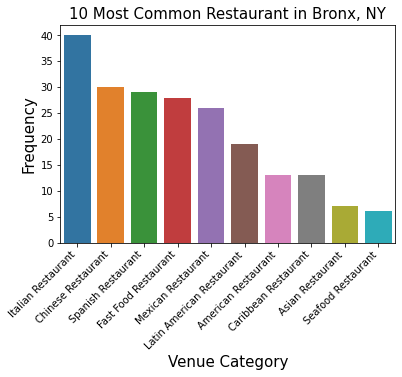

<Figure size 1296x504 with 0 Axes>

In [22]:
s=sns.barplot(x="Venue_Category", y="Frequency", data=df_venues_top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Common Restaurant in Bronx, NY', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

# Part 3: Data manipulation for neighborhood clustering

Analyse the neighborhoods by grouping the neighbourhoods and showing the mean of the frequency of occurrence for each category of restaurants.

In [23]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues_only_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Neighborhood'] = df_venues_only_restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

# New dataframe
print(df_onehot.shape)
df_onehot.head()

(239, 29)


,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Eastern European Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Peruvian Restaurant,Puerto Rican Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,Co-op City,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Eastchester,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Eastchester,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Eastchester,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Eastchester,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()
print(df_grouped.shape)
df_grouped.head()

(47, 29)


,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Eastern European Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Peruvian Restaurant,Puerto Rican Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Allerton,0.0,0.000000,0.0,0.0,0.0,0.500,0.0,0.0,0.000000,0.500000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,Baychester,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,0.000000,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0
2,Bedford Park,0.0,0.000000,0.0,0.0,0.0,0.375,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.125000,0.000000,0.0,0.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0
3,Belmont,0.0,0.035714,0.0,0.0,0.0,0.000,0.0,0.0,0.035714,0.035714,0.0,0.0,0.0,0.642857,0.035714,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0
4,Bronxdale,0.0,0.000000,0.0,0.0,0.0,0.200,0.0,0.0,0.200000,0.000000,0.0,0.0,0.0,0.200000,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0


Display neighborhoods with their respective to 10 most common restaurants.

In [25]:
num_top_venues = 10

for hood in df_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = df_grouped[df_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                             venue  freq
0               Chinese Restaurant   0.5
1             Fast Food Restaurant   0.5
2               African Restaurant   0.0
3        Latin American Restaurant   0.0
4    Vegetarian / Vegan Restaurant   0.0
5                  Thai Restaurant   0.0
6                 Sushi Restaurant   0.0
7               Spanish Restaurant   0.0
8  Southern / Soul Food Restaurant   0.0
9        South American Restaurant   0.0


----Baychester----
                             venue  freq
0               Spanish Restaurant  0.33
1             Fast Food Restaurant  0.33
2               Mexican Restaurant  0.33
3               African Restaurant  0.00
4        Latin American Restaurant  0.00
5    Vegetarian / Vegan Restaurant  0.00
6                  Thai Restaurant  0.00
7                 Sushi Restaurant  0.00
8  Southern / Soul Food Restaurant  0.00
9        South American Restaurant  0.00


----Bedford Park----
                             venue  f

Create a pandas dataframe of neighborhoods with top 10 most common restaurants.

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df_grouped['Neighborhood']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Chinese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Comfort Food Restaurant,Cuban Restaurant
1,Baychester,Spanish Restaurant,Mexican Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant
2,Bedford Park,Chinese Restaurant,Mexican Restaurant,Italian Restaurant,Spanish Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Comfort Food Restaurant
3,Belmont,Italian Restaurant,Spanish Restaurant,Mexican Restaurant,American Restaurant,Eastern European Restaurant,Fast Food Restaurant,Japanese Restaurant,Greek Restaurant,Arepa Restaurant,Asian Restaurant
4,Bronxdale,Italian Restaurant,Spanish Restaurant,Chinese Restaurant,Eastern European Restaurant,Mexican Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant


# Part 4: Building clusters of the neighborhoods in New York City

Use k-means algorithm to develop neighborhood clusters. Plot silhouette score to determine the optimal k for the algorithm.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,5))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [29]:
max_range = 10

grouped_clustering = df_grouped.drop('Neighborhood', 1)

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kmc = grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

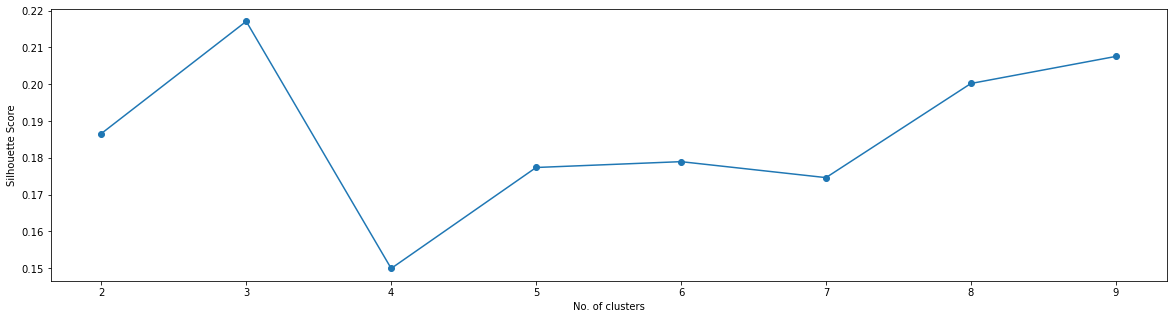

The optimal no. of cluster is 3


In [43]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")
cluster_no = np.arange(2, max_range, 1).tolist()
max_value = max(scores)
max_index = scores.index(max_value)
cluster_no = cluster_no[max_index]
print('The optimal no. of cluster is', cluster_no)

In [31]:
# set number of clusters
kclusters = cluster_no

df_grouped_clustering = df_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [32]:
neighborhoods_venues_sorted_w_clusters = neighborhoods_venues_sorted
neighborhoods_venues_sorted_w_clusters.insert(0, 'Cluster Labels', kmeans.labels_)
df_merged = df.copy()
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
df_merged = df_merged[df_merged['Cluster Labels'].notna()]
df_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bronx,Co-op City,40.874294,-73.829939,0.0,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,1.0,Caribbean Restaurant,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Comfort Food Restaurant
5,Bronx,Kingsbridge,40.881687,-73.902818,0.0,Mexican Restaurant,Latin American Restaurant,Spanish Restaurant,Fast Food Restaurant,Caribbean Restaurant,Seafood Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,French Restaurant
6,Bronx,Woodlawn,40.898273,-73.867315,0.0,Italian Restaurant,American Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant
7,Bronx,Norwood,40.877224,-73.879391,0.0,American Restaurant,Spanish Restaurant,Caribbean Restaurant,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Arepa Restaurant,Asian Restaurant


Create a visual representation of neighborhood clusters on map.

In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Part 5: Examining clusters of the neighborhoods in New York City

***Cluster 1***

In [34]:
label0 = df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]
label0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Co-op City,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant
5,Kingsbridge,Mexican Restaurant,Latin American Restaurant,Spanish Restaurant,Fast Food Restaurant,Caribbean Restaurant,Seafood Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,French Restaurant
6,Woodlawn,Italian Restaurant,American Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant
7,Norwood,American Restaurant,Spanish Restaurant,Caribbean Restaurant,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Arepa Restaurant,Asian Restaurant
9,Baychester,Spanish Restaurant,Mexican Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant
10,Pelham Parkway,Italian Restaurant,Sushi Restaurant,Chinese Restaurant,Mexican Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Comfort Food Restaurant
11,City Island,Seafood Restaurant,Italian Restaurant,American Restaurant,Spanish Restaurant,French Restaurant,Indian Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant
12,Bedford Park,Chinese Restaurant,Mexican Restaurant,Italian Restaurant,Spanish Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Comfort Food Restaurant
13,University Heights,African Restaurant,American Restaurant,Chinese Restaurant,Fast Food Restaurant,Latin American Restaurant,Indian Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Comfort Food Restaurant
15,Fordham,Spanish Restaurant,Fast Food Restaurant,Chinese Restaurant,Latin American Restaurant,African Restaurant,Greek Restaurant,American Restaurant,Caribbean Restaurant,Mexican Restaurant,Arepa Restaurant


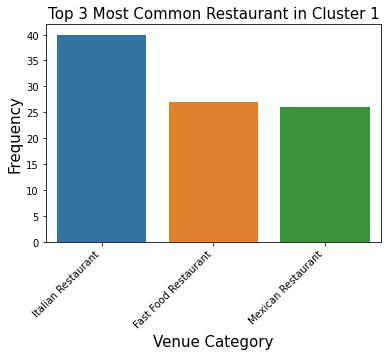

<Figure size 1296x504 with 0 Axes>

In [35]:
n = label0['Neighborhood'].values
cluster1 = df_venues_only_restaurant[df_venues_only_restaurant['Neighborhood'].isin(n)]
cluster1 = cluster1['Venue Category'].value_counts()[0:3].to_frame(name='frequency')
cluster1 = cluster1.reset_index()
cluster1.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)

s=sns.barplot(x="Venue_Category", y="Frequency", data=cluster1)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Top 3 Most Common Restaurant in Cluster 1', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

***Cluster 2***

In [36]:
label1 = df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]
label1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Eastchester,Caribbean Restaurant,Chinese Restaurant,Seafood Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Comfort Food Restaurant
8,Williamsbridge,Caribbean Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Eastern European Restaurant
40,Olinville,Caribbean Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Eastern European Restaurant
45,Claremont Village,Chinese Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Eastern European Restaurant


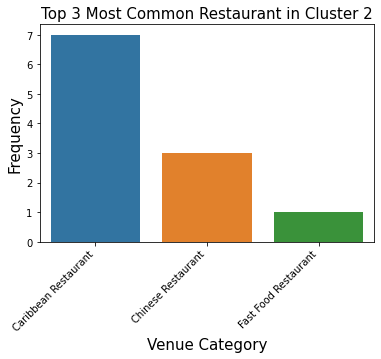

<Figure size 1296x504 with 0 Axes>

In [37]:
n = label1['Neighborhood'].values
cluster2 = df_venues_only_restaurant[df_venues_only_restaurant['Neighborhood'].isin(n)]
cluster2 = cluster2['Venue Category'].value_counts()[0:3].to_frame(name='frequency')
cluster2 = cluster2.reset_index()
cluster2.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)

s=sns.barplot(x="Venue_Category", y="Frequency", data=cluster2)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Top 3 Most Common Restaurant in Cluster 2', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

***Cluster 3***

In [38]:
label2 = df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]
label2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Morris Heights,Spanish Restaurant,Vietnamese Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant
16,East Tremont,Spanish Restaurant,Puerto Rican Restaurant,Vietnamese Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant
20,Mott Haven,Spanish Restaurant,Peruvian Restaurant,Latin American Restaurant,Vietnamese Restaurant,Greek Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant
21,Port Morris,Spanish Restaurant,Peruvian Restaurant,Latin American Restaurant,Vietnamese Restaurant,Greek Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant
23,Hunts Point,Spanish Restaurant,Vietnamese Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant
48,Mount Hope,Spanish Restaurant,Chinese Restaurant,Vietnamese Restaurant,Indian Restaurant,American Restaurant,Arepa Restaurant,Asian Restaurant,Caribbean Restaurant,Comfort Food Restaurant,Cuban Restaurant


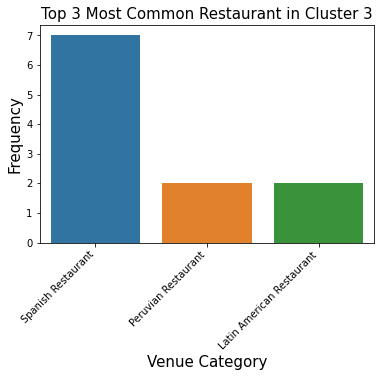

<Figure size 1296x504 with 0 Axes>

In [39]:
n = label2['Neighborhood'].values
cluster3 = df_venues_only_restaurant[df_venues_only_restaurant['Neighborhood'].isin(n)]
cluster3 = cluster3['Venue Category'].value_counts()[0:3].to_frame(name='frequency')
cluster3 = cluster3.reset_index()
cluster3.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)

s=sns.barplot(x="Venue_Category", y="Frequency", data=cluster3)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Top 3 Most Common Restaurant in Cluster 3', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

***Recommendation***

If your favourite cuisine is Italian, you can consider neighborhood cluster 1, which consists of 40 frequency of Italian restaurants. For Spanish food lover, neighborhood cluster 3 is more approriate place to stay, only walking distance to your favourite kitchens!